<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transfer learning with tensorflow part 3: scaling up (food vision mini)

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).
Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-11-08 09:08:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-11-08 09:08:12 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, walk_through_dir, plot_loss_curves, compare_historys, unzip_data

## 101 food classes: working with less data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-11-08 09:08:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 173.194.216.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   103MB/s    in 15s     

2025-11-08 09:08:35 (104 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 image

In [6]:
# setup data inputs

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* create a ModelChecpoint callback
* create a data augmentation layer to build data augmentation right in the model
* build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* compile our model
* feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of the test data to save epoch time)

In [7]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import preprocessing

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name = "data_augmentation")

In [9]:
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augments images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weigts which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Get the summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.1569 - loss: 3.9607 - val_accuracy: 0.4619 - val_loss: 2.5144
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 160ms/step - accuracy: 0.4661 - loss: 2.3712 - val_accuracy: 0.5146 - val_loss: 2.0416
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.5438 - loss: 1.9400 - val_accuracy: 0.5434 - val_loss: 1.8383
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.5800 - loss: 1.7192 - val_accuracy: 0.5524 - val_loss: 1.7687
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.6097 - loss: 1.5605 - val_accuracy: 0.5514 - val_loss: 1.7295


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 79ms/step - accuracy: 0.5605 - loss: 1.6809


[1.6050705909729004, 0.577782154083252]

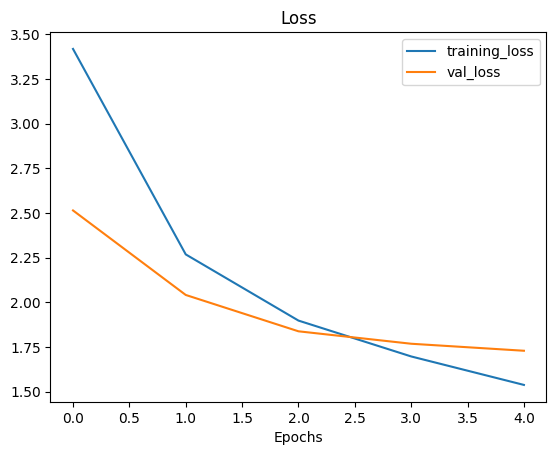

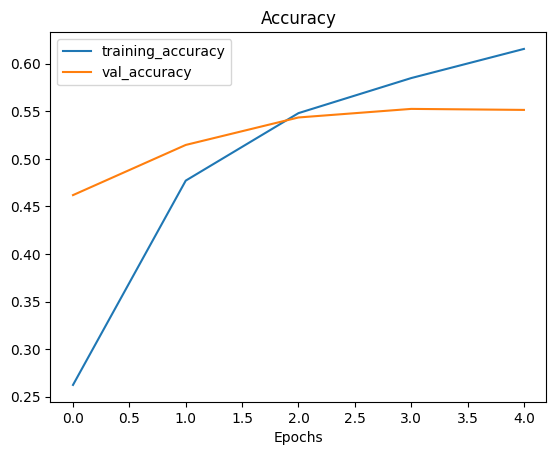

In [13]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning_rate reduced by 10x
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.6236 - loss: 1.5356 - val_accuracy: 0.5694 - val_loss: 1.6758
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.6726 - loss: 1.3347 - val_accuracy: 0.5784 - val_loss: 1.6376
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.6855 - loss: 1.2673 - val_accuracy: 0.5763 - val_loss: 1.6101
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - accuracy: 0.7134 - loss: 1.1748 - val_accuracy: 0.5853 - val_loss: 1.5822
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.7206 - loss: 1.1322 - val_accuracy: 0.5911 - val_loss: 1.5607
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.7264 - loss: 1.0793 - val_accuracy: 0.5903 - val_loss: 1.5587


In [19]:
# Evaluate the whole test_data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.5995 - loss: 1.5105


[1.4264187812805176, 0.6165544390678406]

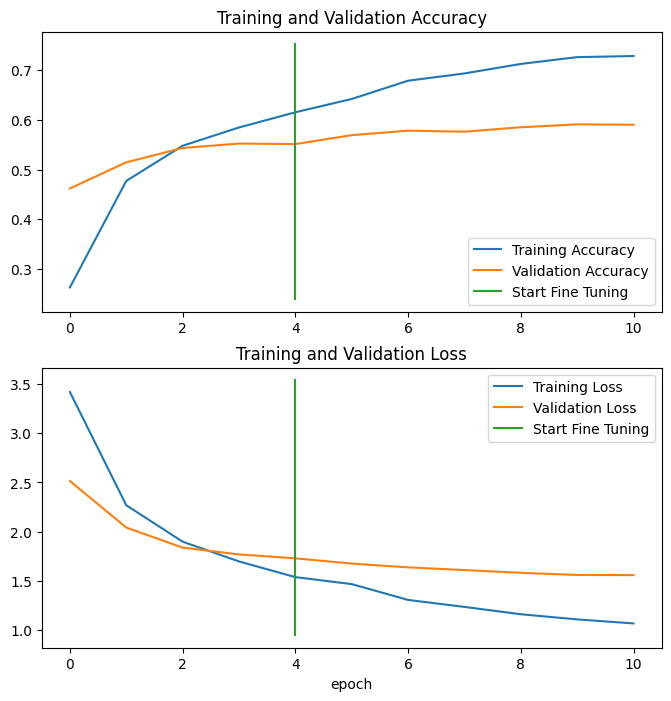

In [20]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                  new_history=history_all_classes_10_percent_fine_tune,
                  initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [21]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [22]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [23]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 77ms/step - accuracy: 0.5995 - loss: 1.5105


[1.4264187812805176, 0.6165544390678406]

In [24]:
# The results from ourloaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4264187812805176, 0.6165544390678406]

## Evaluating the performance of the big dog model across all different classes
Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong

In [25]:
import tensorflow as tf

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_classes_10_percent_saved_big_dog_model.zip

In [26]:
unzip_data('/content/drive/MyDrive/tensorflow_course/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [27]:
!ls -R /content/06_101_food_class_10_percent_saved_big_dog_model/

/content/06_101_food_class_10_percent_saved_big_dog_model/:
assets	saved_model.pb	variables

/content/06_101_food_class_10_percent_saved_big_dog_model/assets:

/content/06_101_food_class_10_percent_saved_big_dog_model/variables:
variables.data-00000-of-00001  variables.index


In [28]:
import tensorflow as tf

# # Load in saved model using tf.saved_model.load
# model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [29]:
# Evaluate the loaded Keras Model on test data
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5995 - loss: 1.5105


[1.4264187812805176, 0.6165544390678406]

## Make predictions with our trained model

In [30]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step


In [31]:
# How many predictions are there?
len(preds_probs)

25250

In [32]:
# What is the shape of our predictions?
preds_probs.shape

(25250, 101)

In [33]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[2.1469343e-01, 3.6443988e-04, 3.8155076e-01, ..., 4.8663882e-05,
        5.2046622e-03, 4.4934046e-03],
       [9.3917692e-01, 2.7602346e-07, 1.1007113e-03, ..., 1.6126209e-03,
        1.8295568e-06, 1.8215022e-05],
       [5.3154075e-01, 4.5623751e-03, 1.6160978e-02, ..., 1.0203985e-03,
        5.0937250e-04, 2.4382269e-03],
       ...,
       [1.8064857e-01, 3.8605926e-05, 3.1995063e-03, ..., 9.1635838e-02,
        4.3352030e-04, 6.4341130e-04],
       [1.6090111e-01, 9.0322865e-04, 2.6357651e-01, ..., 9.6399762e-04,
        4.6500436e-04, 4.2134809e-04],
       [6.6340929e-01, 6.2582840e-06, 8.5360473e-03, ..., 3.2881065e-03,
        1.3627074e-05, 8.4122072e-04]], dtype=float32)

In [34]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([2.1469343e-01, 3.6443988e-04, 3.8155076e-01, 1.2729727e-06,
        9.3872568e-06, 9.1777456e-06, 1.6148042e-04, 2.2931992e-05,
        4.7766268e-02, 7.7452377e-04, 1.8675431e-05, 4.2134649e-05,
        1.9116739e-03, 3.0942724e-06, 8.5929977e-03, 5.2256356e-03,
        6.0542628e-05, 1.7680598e-03, 1.3437799e-02, 2.5185482e-05,
        2.3234328e-03, 9.6494266e-05, 2.4686518e-04, 6.1030331e-04,
        8.2225609e-04, 1.3876080e-03, 1.4181068e-03, 5.9190941e-05,
        3.3755671e-02, 1.2193169e-03, 7.7745062e-06, 6.5169740e-04,
        4.9863453e-04, 2.4660036e-05, 3.1038914e-03, 7.5433374e-05,
        4.1489347e-04, 1.8980006e-03, 1.6776197e-02, 1.8701766e-04,
        5.0627266e-04, 1.1329404e-03, 1.0409765e-03, 3.1718329e-05,
        1.4089698e-04, 4.3649365e-05, 2.7821139e-03, 1.1207225e-04,
        1.1283460e-05, 4.3773670e-02, 5.3068058e-04, 2.5198972e-04,
        7.9534329e-02, 9.7111007e-03, 8.9404130e-05, 1.2550032e-02,
        8.2331030e-03, 3.0609223e-03, 6.5557812e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method

In [35]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: [2.1469343e-01 3.6443988e-04 3.8155076e-01 1.2729727e-06 9.3872568e-06
 9.1777456e-06 1.6148042e-04 2.2931992e-05 4.7766268e-02 7.7452377e-04
 1.8675431e-05 4.2134649e-05 1.9116739e-03 3.0942724e-06 8.5929977e-03
 5.2256356e-03 6.0542628e-05 1.7680598e-03 1.3437799e-02 2.5185482e-05
 2.3234328e-03 9.6494266e-05 2.4686518e-04 6.1030331e-04 8.2225609e-04
 1.3876080e-03 1.4181068e-03 5.9190941e-05 3.3755671e-02 1.2193169e-03
 7.7745062e-06 6.5169740e-04 4.9863453e-04 2.4660036e-05 3.1038914e-03
 7.5433374e-05 4.1489347e-04 1.8980006e-03 1.6776197e-02 1.8701766e-04
 5.0627266e-04 1.1329404e-03 1.0409765e-03 3.1718329e-05 1.4089698e-04
 4.3649365e-05 2.7821139e-03 1.1207225e-04 1.1283460e-05 4.3773670e-02
 5.3068058e-04 2.5198972e-04 7.9534329e-02 9.7111007e-03 8.9404130e-05
 1.2550032e-02 8.2331030e-03 3.0609223e-03 6.5557812e-03 2.8007847e-04
 9.7573402e-06 4.6689585e-03 1.2800683e-02 3.7

In [36]:
test_data.class_names[0]

'apple_pie'

In [37]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 2,  0,  0,  8,  8, 78, 29,  0,  9,  0])

In [38]:
# How many pred classes do we have?
len(pred_classes)

25250

 Now we've got a prediction array of all our model's predictions. to evaluate them, we need to compare them to the labels.

In [39]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] #look at the first 10

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [40]:
len(y_labels)

25250

## Evaluate our model's predictions

In [41]:
results_downloaded_model

[1.4264187812805176, 0.6165544390678406]

In [42]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6165544554455445

In [43]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

np.True_

## Let's get visual: making a confusion matrix

In [44]:
from helper_functions import make_confusion_matrix

In [45]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [46]:
# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically

# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [47]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size = 20)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                           y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.33      0.24      0.28       250
           1       0.53      0.75      0.62       250
           2       0.59      0.67      0.63       250
           3       0.88      0.50      0.63       250
           4       0.56      0.42      0.48       250
           5       0.46      0.49      0.47       250
           6       0.78      0.78      0.78       250
           7       0.82      0.82      0.82       250
           8       0.24      0.63      0.34       250
           9       0.39      0.67      0.50       250
          10       0.53      0.46      0.49       250
          11       0.73      0.67      0.70       250
          12       0.71      0.63      0.67       250
          13       0.55      0.51      0.53       250
          14       0.46      0.64      0.54       250
          15       0.39      0.46      0.42       250
          16       0.68      0.55      0.61       250
          17       0.43    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [49]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels,
                                                  y_pred=pred_classes,
                                                  output_dict=True)
classification_report_dict

{'0': {'precision': 0.3333333333333333,
  'recall': 0.24,
  'f1-score': 0.27906976744186046,
  'support': 250.0},
 '1': {'precision': 0.5297450424929179,
  'recall': 0.748,
  'f1-score': 0.6202321724709784,
  'support': 250.0},
 '2': {'precision': 0.5874125874125874,
  'recall': 0.672,
  'f1-score': 0.6268656716417911,
  'support': 250.0},
 '3': {'precision': 0.8794326241134752,
  'recall': 0.496,
  'f1-score': 0.6342710997442456,
  'support': 250.0},
 '4': {'precision': 0.5608465608465608,
  'recall': 0.424,
  'f1-score': 0.48291571753986334,
  'support': 250.0},
 '5': {'precision': 0.45864661654135336,
  'recall': 0.488,
  'f1-score': 0.4728682170542636,
  'support': 250.0},
 '6': {'precision': 0.7831325301204819,
  'recall': 0.78,
  'f1-score': 0.781563126252505,
  'support': 250.0},
 '7': {'precision': 0.816,
  'recall': 0.816,
  'f1-score': 0.816,
  'support': 250.0},
 '8': {'precision': 0.23716012084592145,
  'recall': 0.628,
  'f1-score': 0.3442982456140351,
  'support': 250.0},

Let's plot all of our classes F!-scores

In [50]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.27906976744186046,
 'baby_back_ribs': 0.6202321724709784,
 'baklava': 0.6268656716417911,
 'beef_carpaccio': 0.6342710997442456,
 'beef_tartare': 0.48291571753986334,
 'beet_salad': 0.4728682170542636,
 'beignets': 0.781563126252505,
 'bibimbap': 0.816,
 'bread_pudding': 0.3442982456140351,
 'breakfast_burrito': 0.49554896142433236,
 'bruschetta': 0.49361702127659574,
 'caesar_salad': 0.6958333333333333,
 'cannoli': 0.6666666666666666,
 'caprese_salad': 0.5280665280665281,
 'carrot_cake': 0.5393634840871022,
 'ceviche': 0.42105263157894735,
 'cheese_plate': 0.6079295154185022,
 'cheesecake': 0.44271844660194176,
 'chicken_curry': 0.5209471766848816,
 'chicken_quesadilla': 0.6738197424892703,
 'chicken_wings': 0.7495219885277247,
 'chocolate_cake': 0.5538461538461539,
 'chocolate_mousse': 0.39776951672862454,
 'churros': 0.7463312368972747,
 'clam_chowder': 0.7385892116182573,
 'club_sandwich': 0.7125506072874493,
 'crab_cakes': 0.3830734966592428,
 'creme_brulee': 0.774

In [51]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [52]:
f1_scores

class_names  f1-score
33        edamame  0.972112
63       macarons  0.884120
45  frozen_yogurt  0.854331
75            pho  0.840467
69        oysters  0.839757
..            ...       ...
8   bread_pudding  0.344298
93          steak  0.333333
82        ravioli  0.318707
0       apple_pie  0.279070
39      foie_gras  0.270270

[101 rows x 2 columns]

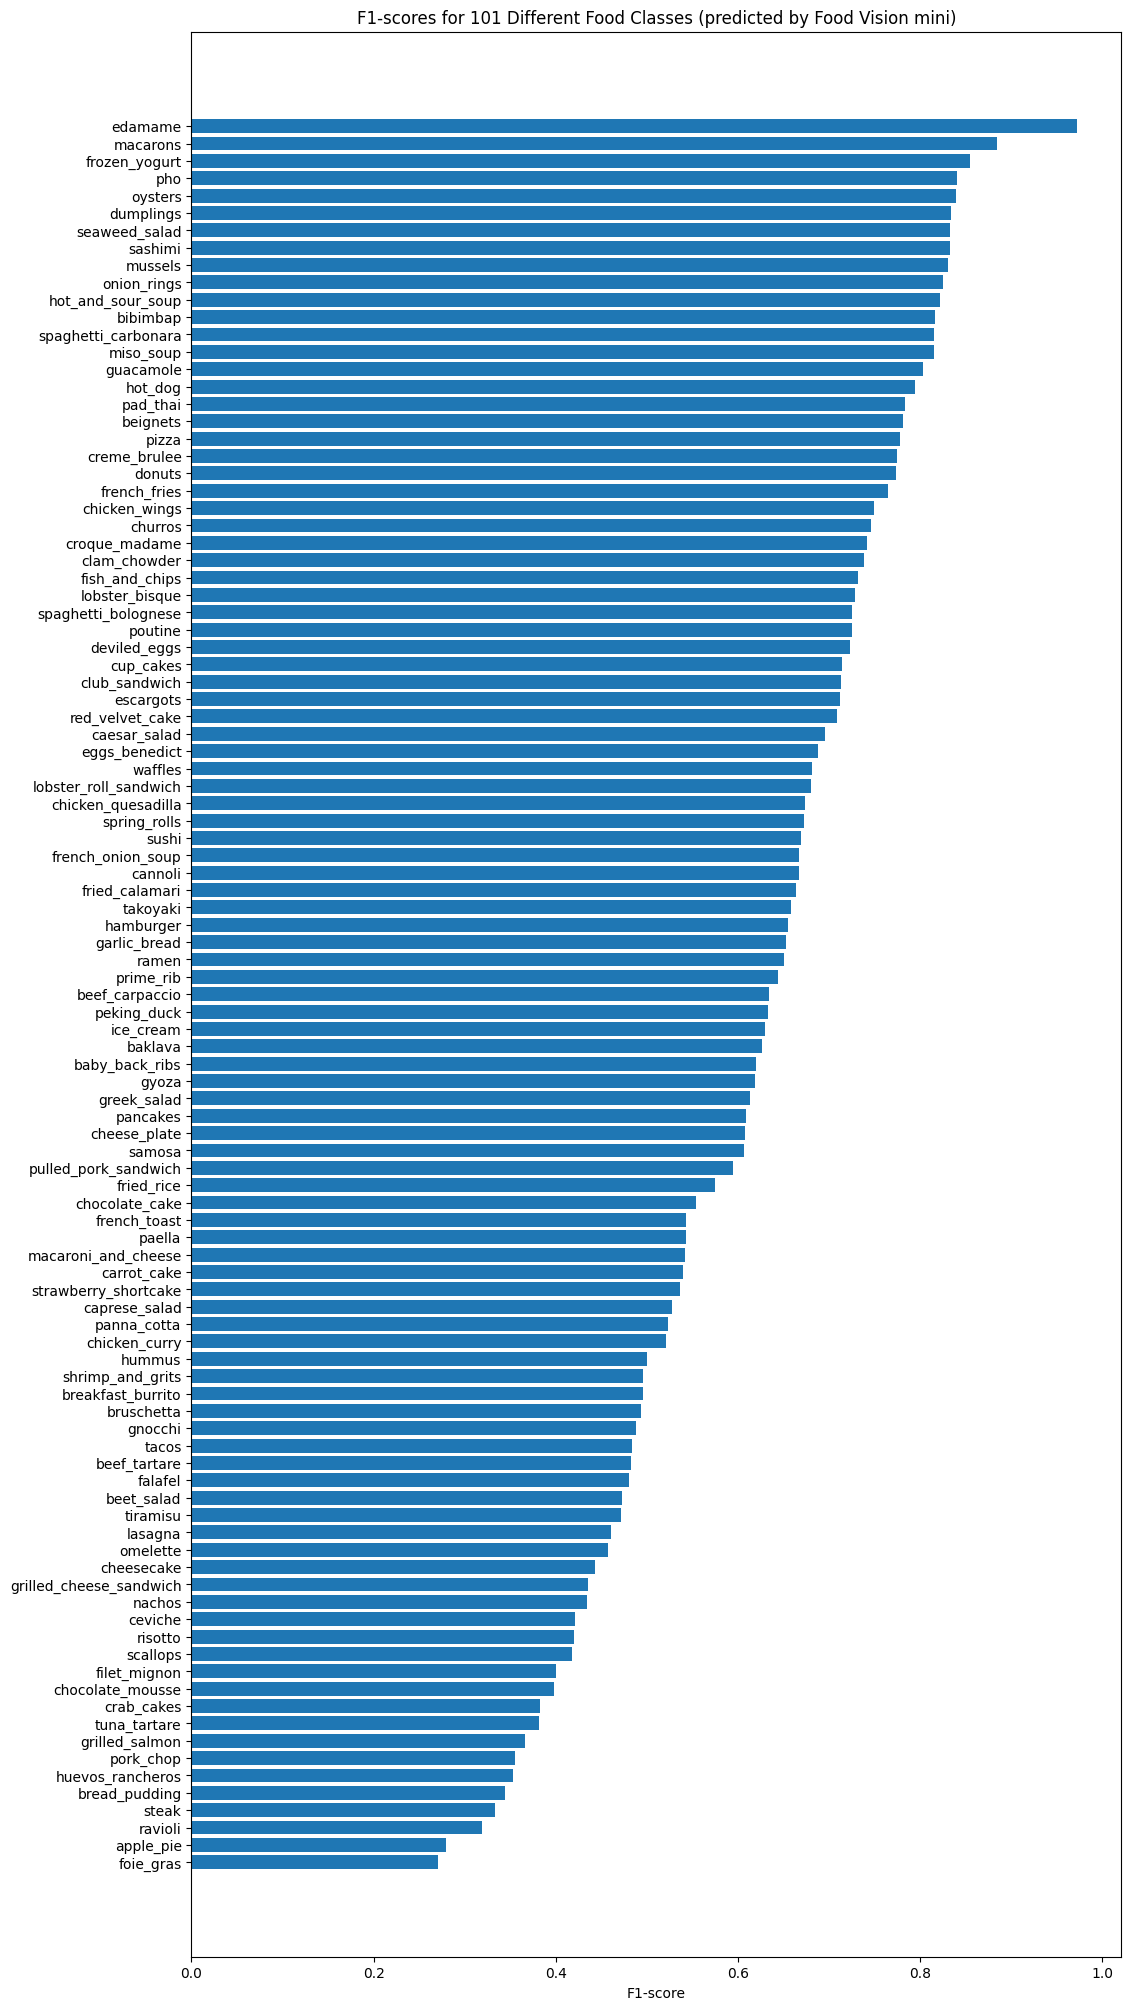

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

## Visualizing predictions on test images

In [54]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): name/path of target image file
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all value between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale for EfficientNet models in TensorFlow

Let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along the model's predcitions, prediction probability and truth label.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
tf.Tensor(
[[[ 90.12755   91.12755   83.12755 ]
  [ 88.07143   89.07143   81.07143 ]
  [ 87.21429   88.        79.57143 ]
  ...
  [254.       254.       254.      ]
  [254.       254.       254.      ]
  [254.       254.       254.      ]]

 [[ 90.        91.        83.      ]
  [ 88.07143   89.07143   81.07143 ]
  [ 87.21429   88.        79.57143 ]
  ...
  [254.       254.       254.      ]
  [254.       254.       254.      ]
  [254.       254.       254.      ]]

 [[ 89.        90.        82.      ]
  [ 89.        90.        82.      ]
  [ 87.33674   88.12245   79.69388 ]
  ...
  [254.       254.       254.      ]
  [254.       254.       254.      ]
  [254.       254.       254.      ]]

 ...

 [[139.07138  149.78563  154.49478 ]
  [145.62747  157.056    163.34166 ]
  [148.62234  161.66824  171.60188 ]
  ...
  [121.214264 124.785736 123.785736]
  [121.42853  125.       124.      ]
  [121.64279  125.214264 124.214264]]

 [[141.52548  149.52548  

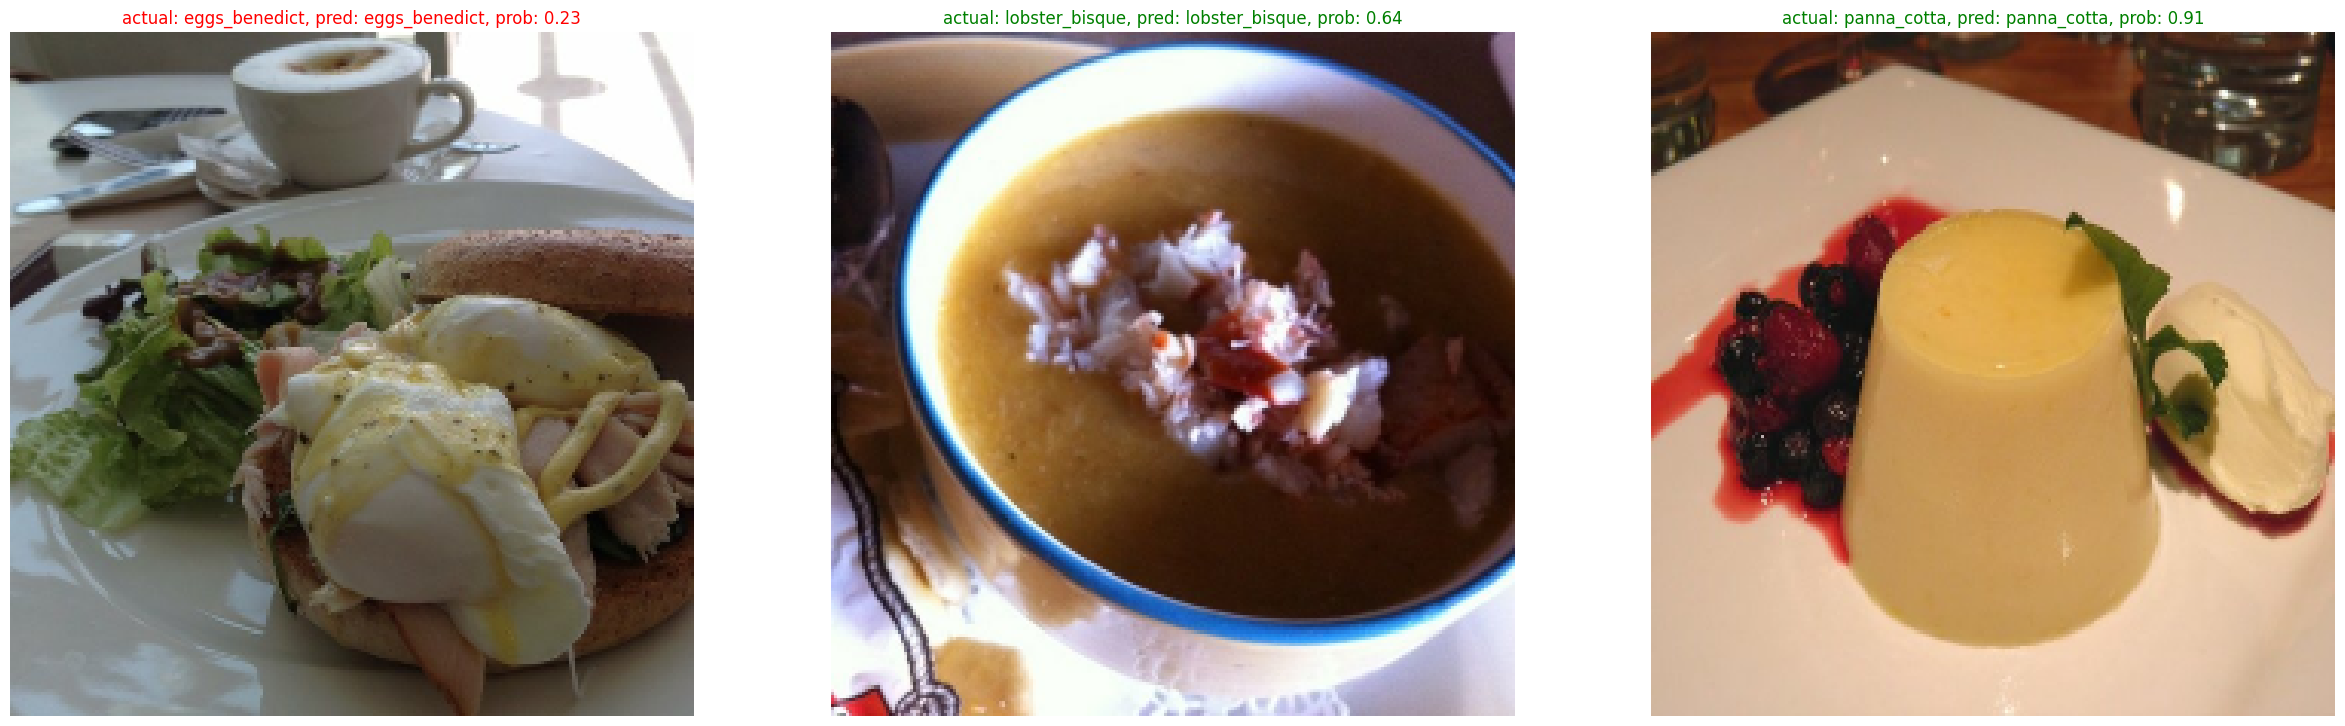

In [63]:
# Make predictions on series of random images
import os
import random

plt.figure(figsize=(30, 10))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name = random.choice(class_names)
  filename =random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make prediction
  img = load_and_prep_image(filepath, scale=False)
  #print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  #print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
  #print(pred_prob)
  #print(pred_class)

  # PLot the images(s)
  plt.subplot(1, 3, i+1)
  print(img)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_colour = "g"
  else:
    title_colour = "r"
  plt.title(f"actual: {class_name}, pred: {class_name}, prob: {pred_prob.max():.2f}", c=title_colour)
  plt.axis(False);

## Finding the most wrong predictions

In [56]:
# 1. Get all the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [57]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0       2   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0       8   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100       8   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname y_pred_classname  
0       0.381551        apple_pie          baklava  
1       0.939177        apple_pie        apple_pie  
2       0.531541        apple_pie        apple_pie  
3       0.230816        apple_pie    bread_pudding  
4       0.686394        apple_pie    bread_pudding  
...          ...              ...              ...  
25245   0.952270          waffles          waffles  
25246   0.665143          waffles     cheese_plate  
25247   0.472682          waffles          waffles  
25248   0.264567          waffles    bread_pudding  
25249   0.682443          waffles          waffles  

[25250 rows x 6 columns]

In [58]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0       2   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0       8   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.381551        apple_pie          baklava         False  
1   0.939177        apple_pie        apple_pie          True  
2   0.531541        apple_pie        apple_pie          True  
3   0.230816        apple_pie    bread_pudding         False  
4   0.686394        apple_pie    bread_pudding         False

In [59]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10013  b'/content/101_food_classes_10_percent/test/fr...      40      43   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
15177  b'/content/101_food_classes_10_percent/test/lo...      60      92   
5652   b'/content/101_food_classes_10_percent/test/ch...      22      98   
...                                                  ...     ...     ...   
1591   b'/content/101_food_classes_10_percent/test/be...       6      85   
5529   b'/content/101_food_classes_10_percent/test/ch...      22      21   
10277  b'/content/101_food_classes_10_percent/test/fr...      41      54   
9690   b'/content/101_food_classes_10_percent/test/fi...      38      20   
6084   b'/content/101_food_classes_10_percent/test/cl...      24      84   

       pred_conf   y_true_classname   y_pred_classname  pred_correct  
11642   0.994116       garlic_bread         bruschetta         False  
10013   0.991126       french_fries     fried_calamari         False  
23797   0.990000              sushi            sashimi         False  
15177   0.989011     lobster_bisque       spring_rolls         False  
5652    0.988631   chocolate_mousse           tiramisu         False  
...          ...                ...                ...           ...  
1591    0.935708           beignets             samosa         False  
5529    0.934792   chocolate_mousse     chocolate_cake         False  
10277   0.932577  french_onion_soup  hot_and_sour_soup         False  
9690    0.932559     fish_and_chips      chicken_wings         False  
6084    0.932301       clam_chowder            risotto         False  

[100 rows x 7 columns]

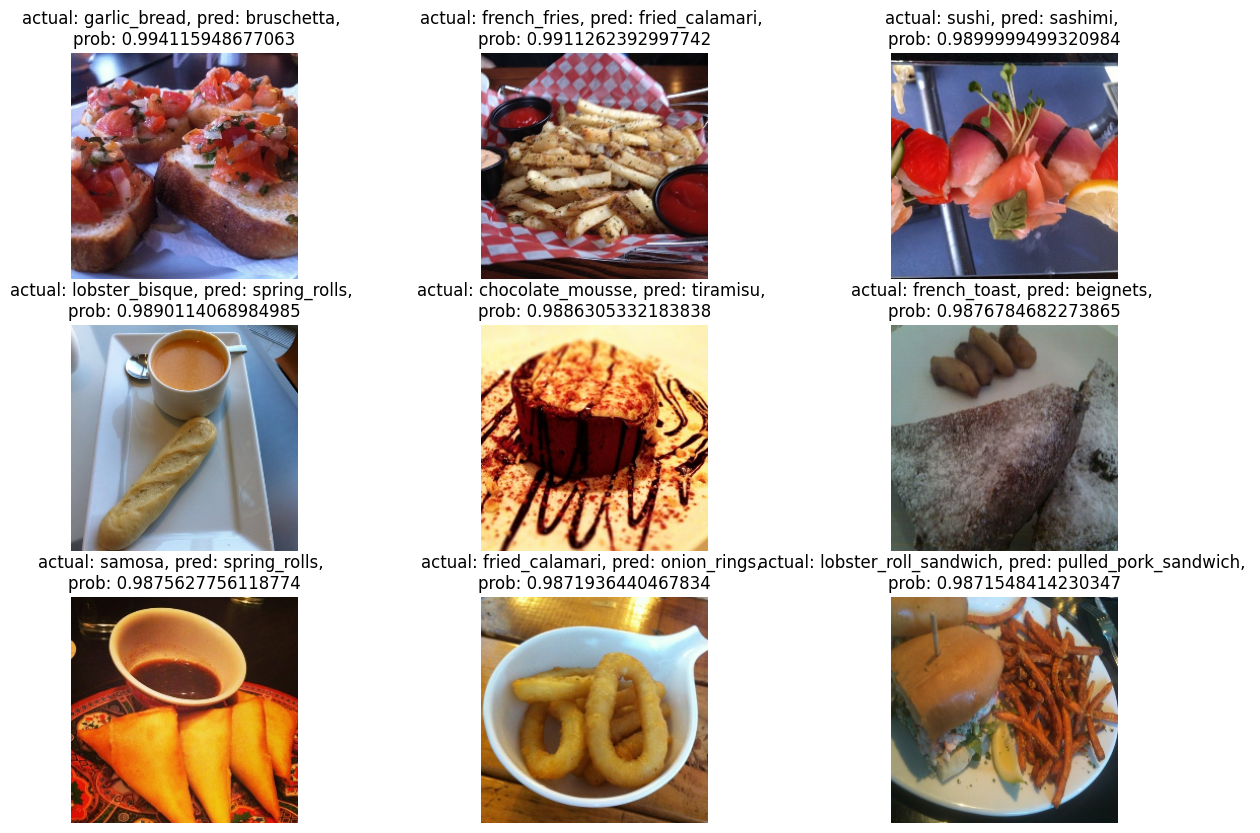

In [66]:
# 5. Visualize the images(test data samples) with highest prediction probabilities but have the wrong probabilities
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False);

## Test out the big dog model on our own custom images

In [61]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2025-11-08 09:24:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 173.194.212.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2025-11-08 09:24:23 (84.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [62]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


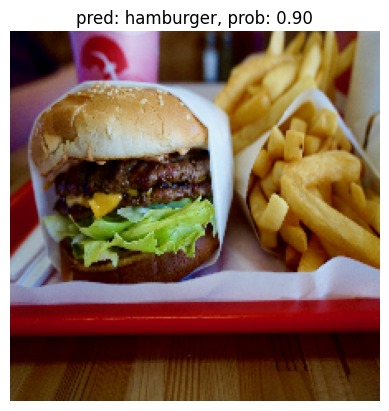

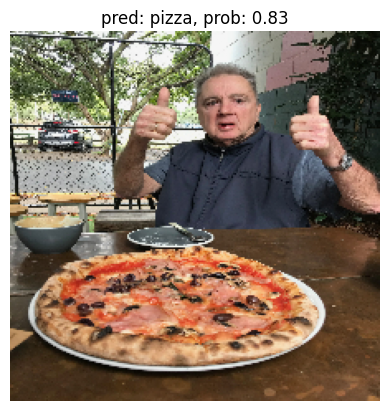

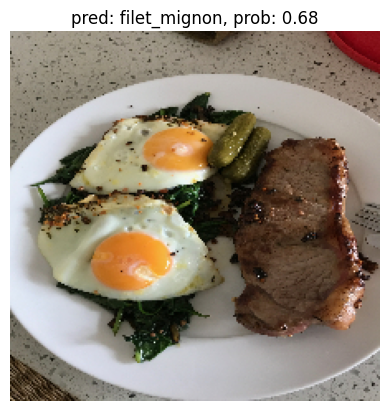

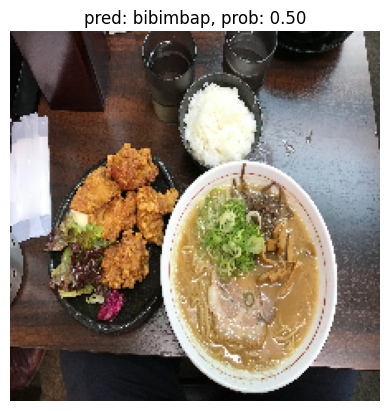

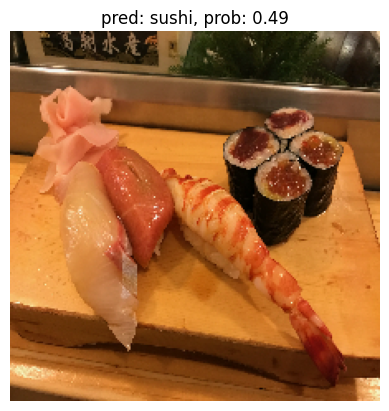

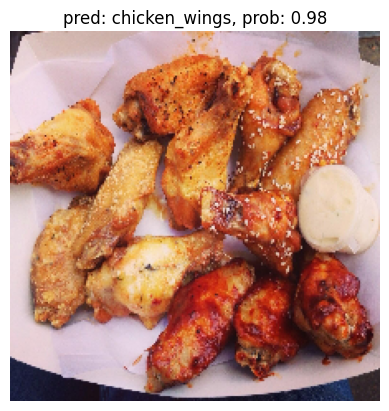

In [67]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # get the index with the highest prediction probability

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)